# StyleGAN2-ADA-PyTorch

**Notes**
* Training and Inference sections should be fairly stable. I’ll slowly add new features but it should work for most mainstream use cases.
* Advanced Features are being documented toward the bottom of this notebook

---

If you find this notebook useful, consider signing up for my [Patreon](https://www.patreon.com/bustbright) or [YouTube channel](https://www.youtube.com/channel/UCaZuPdmZ380SFUMKHVsv_AA/join). You can also send me a one-time payment on [Venmo](https://venmo.com/Derrick-Schultz).

## Setup

Let’s start by checking to see what GPU we’ve been assigned. Ideally we get a V100, but a P100 is fine too. Other GPUs may lead to issues.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2cda156d-d7fe-f649-cc4f-b74fc7941735)


Next let’s connect our Google Drive account. This is optional but highly recommended.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install repo

The next cell will install the StyleGAN repository in Google Drive. If you have already installed it it will just move into that folder. If you don’t have Google Drive connected it will just install the necessary code in Colab.

In [ ]:
import os
!pip install gdown --upgrade

if os.path.isdir("/content/drive/MyDrive/colab-sg2-ada-pytorch"):
    %cd "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch"
elif os.path.isdir("/content/drive/"):
    #install script
    %cd "/content/drive/MyDrive/"
    !mkdir colab-sg2-ada-pytorch
    %cd colab-sg2-ada-pytorch
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    %cd pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch


In [ ]:
#Uninstall new JAX
!pip uninstall jax jaxlib -y
#GPU frontend
!pip install "jax[cuda11_cudnn805]==0.3.10" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#CPU frontend
#!pip install jax[cpu]==0.3.10
#Downgrade Pytorch
!pip uninstall torch torchvision -y
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12 ftfy==6.1.1 ninja==1.10.2 opensimplex

Found existing installation: jax 0.4.4
Uninstalling jax-0.4.4:
  Successfully uninstalled jax-0.4.4
Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
  Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 KB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 MB 5.9 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.10-py3-none-any.whl size=1088066 sha256=4490979dc3ccb90ce7fc3200cf4af8d7c6e0f9e78a4156ae340ae97834533f6c
  Stored in directory: /root/.cache/pip/wheels/14/4a/ff/e9ddfa09012c67d22f926a7873c546c04e722969e8d86f84ec
Successfully built jax
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2

You probably don’t need to run this, but this will update your repo to the latest and greatest.

In [ ]:
%cd "/content/drive/My Drive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch"
!git config --global user.name "test"
!git config --global user.email "test@test.com"
!git fetch origin
!git pull
!git stash
!git checkout origin/main -- train.py generate.py legacy.py closed_form_factorization.py flesh_digression.py apply_factor.py README.md calc_metrics.py training/stylegan2_multi.py training/training_loop.py util/utilgan.py

/content/drive/My Drive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch
Already up to date.
Saved working directory and index state WIP on main: 59e05bb added opensimplex


## Dataset Preparation

Upload a .zip of square images to the `datasets` folder. Previously you had to convert your model to .tfrecords. That’s no longer needed :)

## Train model

Below are a series of variables you need to set to run the training. You probably won’t need to touch most of them.

* `dataset_path`: this is the path to your .zip file
* `resume_from`: if you’re starting a new dataset I recommend `'ffhq1024'` or `'./pretrained/wikiart.pkl'`
* `mirror_x` and `mirror_y`: Allow the dataset to use horizontal or vertical mirroring.

In [ ]:
#required: definitely edit these!
dataset_path = '/content/drive/MyDrive/Fashion_Dataset_Cleaned.zip'
resume_from = '/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00006-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000226.pkl'
aug_strength = 0.329
train_count = 2
mirror_x = False
mirror_y = False

#optional: you might not need to edit these
gamma_value = 50.0
augs = 'bg'
config = '11gb-gpu'
snapshot_count = 4

In [ ]:
!python train.py --gpus=1 --cfg=$config --metrics=None --outdir=./results --data=$dataset_path --snap=$snapshot_count --resume=$resume_from --augpipe=$augs --initstrength=$aug_strength --gamma=$gamma_value --mirror=$mirror_x --mirrory=False --nkimg=$train_count

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 4,
  "network_snapshot_ticks": 4,
  "metrics": [],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/Fashion_Dataset_Cleaned.zip",
    "use_labels": false,
    "max_size": 1680,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 8
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "con

### Resume Training

Once Colab has shutdown, you’ll need to resume your training. Reset the variables above, particularly the `resume_from` and `aug_strength` settings.

1. Point `resume_from` to the last .pkl you trained (you’ll find these in the `results` folder)
2. Update `aug_strength` to match the augment value of the last pkl file. Often you’ll see this in the console, but you may need to look at the `log.txt`. Updating this makes sure training stays as stable as possible.
3. You may want to update `train_count` to keep track of your training progress.

Once all of this has been reset, run that variable cell and the training command cell after it.

## Convert Legacy Model

If you have an older version of a model (Tensorflow based StyleGAN, or Runway downloaded .pkl file) you’ll need to convert to the newest version. If you’ve trained in this notebook you do **not** need to use this cell.

`--source`: path to model that you want to convert

`--dest`: path and file name to convert to.

In [ ]:
!python legacy.py --source=/content/drive/MyDrive/MachineLearningForArtists/MyProject/00016-stylegan_dataset-mirror-paper512-resumecustom/network-snapshot-001693.pkl --dest=/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/runway.pkl

Loading "/content/drive/MyDrive/MachineLearningForArtists/MyProject/00016-stylegan_dataset-mirror-paper512-resumecustom/network-snapshot-001693.pkl"...
/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Saving "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/runway.pkl"...
Done.


## Testing/Inference

Also known as "Inference", "Evaluation" or "Testing" the model. This is the process of usinng your trained model to generate new material, usually images or videos.

### Generate Single Images

`--network`: Make sure the `--network` argument points to your .pkl file. (My preferred method is to right click on the file in the Files pane to your left and choose `Copy Path`, then paste that into the argument after the `=` sign).

`--seeds`: This allows you to choose random seeds from the model. Remember that our input to StyleGAN is a 512-dimensional array. These seeds will generate those 512 values. Each seed will generate a different, random array. The same seed value will also always generate the same random array, so we can later use it for other purposes like interpolation.

`--truncation`: Truncation, well, truncates the latent space. This can have a subtle or dramatic affect on your images depending on the value you use. The smaller the number the more realistic your images should appear, but this will also affect diversity. Most people choose between 0.5 and 1.0, but technically it's infinite. 


In [ ]:
!python generate.py --outdir=/content/out/images/ --trunc=0.8 --seeds=0 --network=/content/drive/MyDrive/ladiescrop-network-snapshot-012885.pkl

#### Non-Square outputs

We can modify the model to output images that are not square. This isn’t as good as training a rectangular model, but with the right model it can still look nice.

* `--size` size takes in a value of `xdim-ydim`. For example, to generate a 1920x1080 image use `1920-1080`
* `--scale-type` This determines the padding style to apply in the additional space. There are four options: `pad`, `padside`, `symm`, and `symmside`. I recommend trying each one to see what works best with your images.


In [ ]:
!python generate.py --outdir=/content/out/images/ --trunc=0.7 --size=1820-1024 --scale-type=symm --seeds=0-499 --network=/content/crystal.pkl

We can use these options for any image or video generation commands (excluding projection).

### Truncation Traversal

Below you can take one seed and look at the changes to it across any truncation amount. -1 to 1 will be pretty realistic images, but the further out you get the weirder it gets.

#### Options 
`--network`: Again, this should be the path to your .pkl file.

`--seeds`: Pass this only one seed. Pick a favorite from your generated images.

`--start`: Starting truncation value.

`--stop`: Stopping truncation value. This should be larger than the start value. (Will probably break if its not).

`--increment`: How much each frame should increment the truncation value. Make this really small if you want a long, slow interpolation. (stop-start/increment=total frames)


In [ ]:
!python generate.py --process="truncation" --outdir=/content/out/trunc-trav-3/ --start=-0.8 --stop=2.8 --increment=0.02 --seeds=470 --network=/content/drive/MyDrive/stylegan2-transfer-models/mixed6k-network-snapshot-016470.pkl

### Interpolations

Interpolation is the process of generating very small changes to a vector in order to make it appear animated from frame to frame.

We’ll look at different examples of interpolation below.

#### Options

`--network`: path to your .pkl file

`--interpolation`: Walk type defines the type of interpolation you want. In some cases it can also specify whether you want the z space or the w space.

`--frames`: How many frames you want to produce. Use this to manage the length of your video.

`--trunc`: truncation value

#### Linear Interpolation

In [ ]:
!python generate.py --outdir=/content/out/video1-w-0.5/ --space="z" --trunc=0.5 --process="interpolation" --seeds=463,470 --network=/content/drive/MyDrive/stylegan2-transfer-models/mixed6k-network-snapshot-016470.pkl

In [ ]:
!python generate.py --outdir=out/video1-w/ --space="w" --trunc=1 --process="interpolation" --seeds=85,265,297,849 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl

#### Slerp Interpolation

This gets a little heady, but technically linear interpolations are not the best in high-dimensional GANs. [This github link](https://github.com/soumith/dcgan.torch/issues/14) is one of the more popular explanations ad discussions.

In reality I do not find a huge difference between linear and spherical interpolations (the difference in z- and w-space is enough in many cases), but I’ve implemented slerp here for anyone interested.

In [ ]:
!python generate.py --outdir=out/slerp-z/ --space="z" --trunc=1 --process="interpolation" --interpolation="slerp" --seeds=85,265,297,849 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl --frames=24

In [ ]:
!python generate.py --outdir=out/slerp-w/ --space="w" --trunc=1 --process="interpolation" --interpolation="slerp" --seeds=85,265,297,849 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl --frames=12

#### Noise Loop

If you want to just make a random but fun interpolation of your model the noise loop is the way to go. It creates a random path thru the z space to show you a diverse set of images.

`--interpolation="noiseloop"`: set this to use the noise loop funtion

`--diameter`: This controls how "wide" the loop is. Make it smaller to show a less diverse range of samples. Make it larger to cover a lot of samples. This plus `--frames` can help determine how fast the video feels.

`--random_seed`: this allows you to change your starting place in the z space. Note: this value has nothing to do with the seeds you use to generate images. It just allows you to randomize your start point (and if you want to return to it you can use the same seed multiple times).

Noise loops currently only work in z space.

In [ ]:
!python generate.py --outdir=out/video-noiseloop-0.9d/ --trunc=0.8 --process="interpolation" --interpolation="noiseloop" --diameter=0.9 --random_seed=100 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl

#### Circular Loop

The noise loop is, well, noisy. This circular loop will feel much more even, while still providing a random loop.

I recommend using a higher `--diameter` value than you do with noise loops. Something between `50.0` and `500.0` alongside `--frames` can help control speed and diversity.

In [ ]:
!python generate.py --outdir=out/video-circularloop/ --trunc=1 --process="interpolation" --interpolation="circularloop" --diameter=800.00 --frames=720 --random_seed=90 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl

## Projection

### Basic Projector

*   `--target`: this is a path to the image file that you want to "find" in your model. This image must be the exact same size as your model.
*   `--num-steps`: how many iterations the projctor should run for. Lower will mean less steps and less likelihood of a good projection. Higher will take longer but will likely produce better images.



In [ ]:
!python projector.py --help

In [ ]:
!python projector.py --network=/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00023-chin-morris-mirror-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000304.pkl --outdir=/content/projector/ --target=/content/img005421_0.png --num-steps=200 --seed=0

### Peter Baylies’ Projector

In [ ]:
!python /content/stylegan2-ada-pytorch/pbaylies_projector.py --help

In [ ]:
!python /content/stylegan2-ada-pytorch/pbaylies_projector.py --network=/content/ladiesblack.pkl --outdir=/content/projector-no-clip-006265-4-inv-3k/ --target-image=/content/img006265-4-inv.png --num-steps=3000 --use-clip=False --use-center=False --seed=99

## Combine NPZ files together

In [ ]:
!python combine_npz.py --outdir=/content/npz --npzs='/content/projector-no-clip-006264-1-inv-3k/projector-no-clip-006264-1-inv-3k.npz,/content/projector-no-clip-006265-1-inv-3k/projector-no-clip-006265-1-inv-3k.npz,/content/projector-no-clip-006264-5-inv-3k/projector-no-clip-006264-5-inv-3k.npz,/content/projector-no-clip-006265-3-inv-3k/projector-no-clip-006265-3-inv-3k.npz,/content/projector-no-clip-006265-4-inv-3k/projector-no-clip-006265-4-inv-3k.npz,/content/projector-no-clip-006264-1-inv-3k/projector-no-clip-006264-1-inv-3k.npz'

In [ ]:
!python generate.py --help

In [ ]:
!python generate.py --process=interpolation --interpolation=linear --easing=easeInOutQuad --space=w --network=/content/ladiesblack.pkl --outdir=/content/combined-proj/ --projected-w=/content/npz/combined.npz --frames=120

## Feature Extraction using Closed Form Factorization

Feature Extraction is the process of finding “human readable” vectors in a StyleGAN model. For example, let’s say you wanted to find a vector that could open or close a mouth in a face model.

The feature extractor tries to automate the procss of finding important vectors in your model.

`--ckpt`: This is the path to your .pkl file. In other places its called `--network` (It’s a long story for why its name changed here)
`--out`: path to save your output feature vector file. The file name must end in `.pt`!

In [ ]:
!python closed_form_factorization.py --out=/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pt --ckpt=/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl

Loading networks from "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl"...


Once this cell is finished you’ll want to save that `.pt` file somewhere for reuse.

This process just created the vctor values, but we need to test it on some seed values to determine what each vector actually changes. The `apply_factor.py` script does this.

Arguments to try:


*   `-i`: This stands for index. By default, the cell above will produce 512 vectors, so `-i` can be any value from 0 to 511. I recommend starting with a higher value.
*   `-d`: This stands for degrees. This means how much change you want to see along th vector. I recommend a value between 5 and 10 to start with.
*   `--seeds`: You know what these are by now right? :)
*   `--ckpt`: path to your .pkl file
*   `--video`: adding this to your argument will produce a video that animates your seeds along the vector path. I find it much easier to figure out what’s changing with an animation.
*   `--output`: where to save the images/video
*   `--space`: By default this will use the w space to reduce entanglement

Lastly you need to add the path to the `.pt` file you made in th above cell. It’s weird, but you don’t need to add any arguments bfore it, just make sure its after `apply_factor.pt`



In [ ]:
ads = 1, 2, 3
dfs = -5, 5, 7

In [ ]:
import os
import re
import subprocess
import argparse
import torch
from torchvision import utils # assumes you use torchvision 0.8.2; if you use the latest version, see comments below
import legacy
import dnnlib
from typing import List
import numpy as np
import random

"""
Use closed_form_factorization.py first to create your factor.pt

Usage:

python apply_factor.py -i 1-3 --seeds 10,20 --ckpt models/ffhq.pkl factor.pt --video
Create images and interpolation videos for image-seeds 10 and 20 for eigenvalues one, two and three.

python apply_factor.py -i 10,20 --seeds 100-200 --ckpt models/ffhq.pkl factor.pt --no-video
Create images for each image-seed between 100 and 200 and for eigenvalues 10 and 20.

python apply_factor.py --seeds r3 --ckpt models/ffhq.pkl factor.pt --no-video
Create images for three random seeds and all eigenvalues (this can take a lot of time, especially for videos).

Apply different truncation values by using --truncation.
Apply different increment degree for interpolation video by using --vid_increment.
Apply different scalar factors for moving latent vectors along eigenvector by using --degree.
Change output directory by using --output.
"""

#############################################################################################

def generate_images_multiIndex_new(z, label, truncation_psi, noise_mode, d1, d2, d3, file_name):
    if(args.space == 'w'):
        ws = zs_to_ws(G,torch.device('cuda'),label,truncation_psi,[z - d1 - d2 - d3, z, z + d1 + d2 + d3])
        img1 = G.synthesis(ws[0], noise_mode=noise_mode, force_fp32=True)
        img2 = G.synthesis(ws[1], noise_mode=noise_mode, force_fp32=True)
        img3 = G.synthesis(ws[2], noise_mode=noise_mode, force_fp32=True)
    else:
        img1 = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img2 = G(z + direction, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img3 = G(z - direction, label, truncation_psi=truncation_psi, noise_mode=noise_mode)

    return torch.cat([img3, img1, img2], 0)

def generate_images(z, label, truncation_psi, noise_mode, direction, file_name):
    if(args.space == 'w'):
        ws = zs_to_ws(G,torch.device('cuda'),label,truncation_psi,[z,z + direction,z - direction])
        img1 = G.synthesis(ws[0], noise_mode=noise_mode, force_fp32=True)
        img2 = G.synthesis(ws[1], noise_mode=noise_mode, force_fp32=True)
        img3 = G.synthesis(ws[2], noise_mode=noise_mode, force_fp32=True)
    else:
        img1 = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img2 = G(z + direction, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img3 = G(z - direction, label, truncation_psi=truncation_psi, noise_mode=noise_mode)

    return torch.cat([img3, img1, img2], 0)

def generate_image(z, label, truncation_psi, noise_mode, space):
    if(space == 'w'):
        img = G.synthesis(z, noise_mode=noise_mode, force_fp32=True)
    else:
        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    return img

def line_interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            t = index/float(steps)
            out.append(zs[i+1]*t + zs[i]*(1-t))
    return out

def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c', a range 'a-c' and return as a list of ints or a string with "r{number}".'''
    if "r" in s:
        index = s.index("r")
        return int(s[index+1:])
    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]

def zs_to_ws(G,device,label,truncation_psi,zs):
    ws = []
    for z_idx, z in enumerate(zs):
        # z = torch.from_numpy(z).to(device)
        w = G.mapping(z, label, truncation_psi=truncation_psi, truncation_cutoff=8)
        ws.append(w)
    return ws

############################################################################################


In [ ]:
import os
import re
import subprocess
import argparse
import torch
from torchvision import utils # assumes you use torchvision 0.8.2; if you use the latest version, see comments below
import legacy
import dnnlib
from typing import List
import numpy as np
import random


torch.set_grad_enabled(False)

ckpt = "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl"
factor = "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pt"
seeds = [2]
index = [1, 2, 3]
truncation = 0.7
increments = 0.1
degrees = [10, 10, 6]
space = 'w'

device = torch.device('cuda')
eigvec = torch.load(factor)["eigvec"].to(device)

custom = False

G_kwargs = dnnlib.EasyDict()
G_kwargs.size = None 
G_kwargs.scale_type = 'symm'

print('Loading networks from "%s"...' % ckpt)
device = torch.device('cuda')
with dnnlib.util.open_url(ckpt) as f:
  G = legacy.load_network_pkl(f, custom=custom, **G_kwargs)['G_ema'].to(device) # type: ignore


label = torch.zeros([1, G.c_dim], device=device) # assume no class label
noise_mode = "const" # default
truncation_psi = truncation

latents = []
mode = "random"
log_str = ""

index_list_of_eigenvalues = []

if isinstance(seeds, int):
    for i in range(seeds):
        latents.append(random.randint(0,2**32-1)) # 2**32-1 is the highest seed value
    mode = "random"
    log_str = str(seeds) + " samples"
else:
    latents = seeds
    mode = "seeds"
    log_str = str(seeds)


for l in latents:
        print(f"Generate images for seed ", l)

        z = torch.from_numpy(np.random.RandomState(l).randn(1, G.z_dim)).to(device)

        file_name = ""
        image_grid_eigvec = []

        index_list_of_eigenvalues = index

        k = 0
        for j in index_list_of_eigenvalues:
            current_eigvec = eigvec[:, j].unsqueeze(0)
            direction = degrees[k] * current_eigvec
            z = z + direction
            k = k + 1

        ws = zs_to_ws(G,torch.device('cuda'),label,truncation_psi,[z])

        img = generate_image(ws[0], label, truncation_psi, noise_mode, space)

Loading networks from "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl"...
Generate images for seed  2


In [ ]:
grid = utils.save_image(
                        img,
                        f"test.png",
                        normalize=True,
                        value_range=(-1, 1), # change range to value_range for latest torchvision
                        nrow=1,
                    )

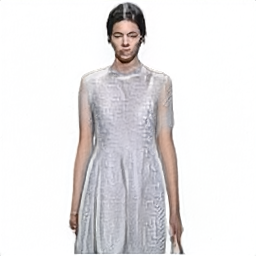

In [ ]:
from PIL import Image

image = Image.open("test.png")

image.show()

In [ ]:
!python apply_factor.py -i 1,52,8 --degrees 10,-5,4 --seeds 11 --ckpt /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pt --output /content/cff-vid/

Loading networks from "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl"...

    Checkpoint: /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl
    Factor: /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pt
    Outpur Directory: /content/cff-vid/
    Mode: seeds ([11])
    Index: eigenvectors [1, 52, 8]
    Truncation: 0.7
    Video: False
    Video Increments: 0.1
    
Generate images for seed  11
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


That just produced images or video for a single vector, but there are 511 more! To generate every vector, you can uuse the cell below. Update any arguments you want, but don’t touch the `-i {i}` part.

**Warning:** This takes a long time, especially if you have more than one seed value (pro tip: don’t usee more than one seed value)! Also, this will take up a good amount of space in Google Drive. You’ve been warned!

In [ ]:
for i in range(0,512, 50):
  !python apply_factor.py -i {i} -d 10 --seeds 101 --ckpt /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pkl /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/results/00002-Fashion_Dataset_Cleaned-11gb-gpu-gamma50-bg-resumecustom/network-snapshot-000256.pt --output /content/cff-vid/ --video

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.war

# Layer Manipulations

The following scripts allow you to modify various resolution layers of the StyleGAN model.

## Flesh Digressions

Flesh Digressions works by manipulating the vectors in the base 4x4 layer. By doing this while leaving all the other layers untouched you can create a warping and twisting version of images from your model.

In [ ]:
!python flesh_digression.py --pkl /content/stylegan2-ada-pytorch/pretrained/wikiart.pkl --psi 0.5 --seed 9999

In [ ]:
!python blend_models.py --lower_res_pkl /content/ffhq-pt.pkl --split_res 64 --higher_res_pkl /content/bone-bone-pt.pkl --output_path /content/ffhq-bonebone-split64.pkl

You can now take the output .pkl file and use that with any of the generation tools above.

# Gradio


In [ ]:
selected_model = 'lookbook'

# Load model
import torch
import numpy as np
from PIL import Image
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config

# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN2',
  layer='style',
  output_class=selected_model,
  components=20,
  use_w=True,
  batch_size=5_000, # style layer quite small
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, device, use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model

comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []

load_activations = False

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])

In [ ]:
import gradio as gr
import numpy as np

def generate_image(seed, c0, c1, c2, c3, c4, c5, c6):
    seed = int(seed)
    params = {'c0': c0,
          'c1': c1,
          'c2': c2,
          'c3': c3,
          'c4': c4,
          'c5': c5,
          'c6': c6}

    # Assigns slider to the principal components
    param_indexes = {'c0': 0,
              'c1': 1,
              'c2': 2,
              'c3': 3,
              'c4': 4,
              'c5': 5,
              'c6': 6}

    # Save the values from the sliders
    directions = []
    distances = []
    for k, v in params.items():
        directions.append(latent_dirs[param_indexes[k]])
        distances.append(v)

    # Additional settings for image generation
    start_layer = 0
    end_layer = 14
    truncation = 0.5
    
    return display_sample_pytorch(seed, truncation, directions, distances, scale, int(start_layer), int(end_layer), disp=False)

# Create a number input for seed
seed = gr.inputs.Number(default=0, label="Seed 1")

slider_max_val = 20
slider_min_val = -20
slider_step = 1

# Create the sliders input
c0 = gr.inputs.Slider(label="Sleeve & Size", minimum=slider_min_val, maximum=slider_max_val, default=0)
c1 = gr.inputs.Slider(label="Dress - Jacket", minimum=slider_min_val, maximum=slider_max_val, default=0)
c2 = gr.inputs.Slider(label="Female Coat", minimum=slider_min_val, maximum=slider_max_val, default=0)
c3 = gr.inputs.Slider(label="Coat", minimum=slider_min_val, maximum=slider_max_val, default=0)
c4 = gr.inputs.Slider(label="Graphics", minimum=slider_min_val, maximum=slider_max_val, default=0)
c5 = gr.inputs.Slider(label="Dark", minimum=slider_min_val, maximum=slider_max_val, default=0)
c6 = gr.inputs.Slider(label="Less Cleavage", minimum=slider_min_val, maximum=slider_max_val, default=0)


inputs = [seed, c0, c1, c2, c3, c4, c5, c6]

# Launch demo
gr.Interface(generate_image, inputs, ["image"], live=True, title="ClothingGAN").launch(debug=True)